# Case Study 7 - Produce farm zone map
## Description 
As a grower, I want to analyse my yield maps and farm data, so I can zone up my farm based on site variability. 
## Case Breakdown 
- **Actors:** Grower
- **Goals:** Customized needs for Grower
- **Scope** Local,Paddock-Scale
## Generalised case
I want to analyse a suite of spatial variables across a site so I can derive a classification of areas by similarity.
## Comparable cases
- I want to combine a suite of environmental variables, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5) and soils (pH, N, K, structure) for N (e.g. 50) candidate sites and then select derive a classification for each subunit based on a clustering algorithm.
## Stakeholders 
- **Name:** Tom Bishop
- **Contact:** thomas.bishop@sydney.edu.au


## Data Sources
Use Llara-Campey data including yield values and soil maps to develop classification of farm area into contiguous zones of relatively self-similar productivity. Variables should include the minimum zone area and the maximum number of zone classes to return.

This notebook can be delivered as a tool into which the user can load their own data in the form of spreadsheets containing points and associated values for the variables to take into account in the analysis. The requirement is either for comprehensive (raster) coverage for the area or of a set of point-based measurements for each variable (in which case a simple kriging or mesh interpolation will be applied).

### Generating STAC records from config files

In [10]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core import StacCollectionConfig , StacSerialiser
from pathlib import Path 
import numpy as np 

parent_path = Path().cwd()
# Scenario 1
configs = [
    parent_path / "llara_point_config.json",
    parent_path / "llara_raster_config.json",
    parent_path / "llara_shape_config.json",
    parent_path / "scenario_1_config.json"
]
output_path = parent_path / "scenario_1"
collection_config = StacCollectionConfig(id="Collection")

# Serialising STAC records
with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(source_configs=configs, collection_config=collection_config, pool=pool)
    serialiser = StacSerialiser(generator, output_path.as_posix())
    serialiser() 

2025-05-12T13:46:48-stac_generator.core.point.generator - INFO - Reading point asset: soil_measurement
2025-05-12T13:46:48-stac_generator.core.raster.generator - INFO - Reading raster asset: CampeyECa
2025-05-12T13:46:48-stac_generator.core.raster.generator - INFO - Reading raster asset: LlaraECa
2025-05-12T13:46:48-stac_generator.core.vector.generator - INFO - Reading vector asset: L1Boundary
2025-05-12T13:46:48-stac_generator.core.vector.generator - INFO - Reading vector asset: L3Boundary
2025-05-12T13:46:48-stac_generator.core.vector.generator - INFO - Reading vector asset: L4Boundary
2025-05-12T13:46:48-stac_generator.core.raster.generator - INFO - Reading raster asset: LlaraGammaK
2025-05-12T13:46:48-stac_generator.core.raster.generator - INFO - Reading raster asset: CampeyGammaK
2025-05-12T13:46:49-stac_generator.core.point.generator - INFO - Reading point asset: L1_2017_wheat
2025-05-12T13:46:49-stac_generator.core.point.generator - INFO - Reading point asset: L3_2017_wheat
2025

### Loading raw data using the MCCN Engine

In [80]:
# Loading in data cube 
from mccn.client import MCCN 

client = MCCN(endpoint = output_path/"collection.json", shape=(100, 100))
raw_ds = client.load()

In [81]:
raw_ds

<xarray.Dataset> Size: 5MB
Dimensions:                                 (time: 3, y: 100, x: 100)
Coordinates:
  * y                                       (y) float64 800B -30.25 ... -30.29
  * x                                       (x) float64 800B 149.8 ... 149.9
    spatial_ref                             int32 4B 4326
  * time                                    (time) datetime64[ns] 24B 2016-01...
Data variables: (12/24)
    eca                                     (time, y, x) float64 240kB 0.0 .....
    gammak                                  (time, y, x) float64 240kB 0.0 .....
    L1Boundary                              (time, y, x) int8 30kB 0 0 0 ... 0 0
    L3Boundary                              (time, y, x) int8 30kB 0 0 0 ... 0 0
    L4Boundary                              (time, y, x) int8 30kB 0 0 0 ... 0 0
    Inorganic carbon (TC-OC)                (time, y, x) float64 240kB 0.0 .....
    ...                                      ...
    Clay                                    (time, y, x) float64 240kB 0.0 .....
    Sand                                    (time, y, x) float64 240kB 0.0 .....
    Total Carbon (Combustion)               (time, y, x) float64 240kB 0.0 .....
    Organic Carbon                          (time, y, x) float64 240kB 0.0 .....
    yield_t_ha                              (time, y, x) float64 240kB 0.0 .....
    moisture                                (time, y, x) float64 240kB 0.0 .....
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

### Preprocessing - Removing invalid data

We notice that raster layers have -3.4e-38 nodata values. For simplicity, we constrain the valid values to be in [-1e3, 1e3]

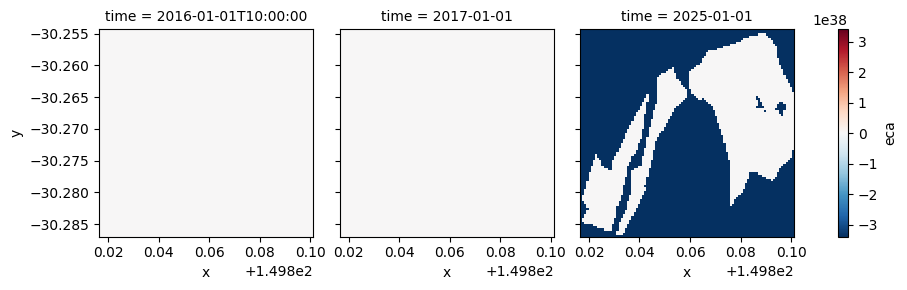

In [82]:
raw_ds["eca"].plot(x="x", y="y", col="time", col_wrap=3)

In [83]:
proc_ds = raw_ds.where((-1e3 <= raw_ds) & (raw_ds <= 1e3), np.nan)
proc_ds

<xarray.Dataset> Size: 6MB
Dimensions:                                 (time: 3, y: 100, x: 100)
Coordinates:
  * y                                       (y) float64 800B -30.25 ... -30.29
  * x                                       (x) float64 800B 149.8 ... 149.9
    spatial_ref                             int32 4B 4326
  * time                                    (time) datetime64[ns] 24B 2016-01...
Data variables: (12/24)
    eca                                     (time, y, x) float64 240kB 0.0 .....
    gammak                                  (time, y, x) float64 240kB 0.0 .....
    L1Boundary                              (time, y, x) float64 240kB 0.0 .....
    L3Boundary                              (time, y, x) float64 240kB 0.0 .....
    L4Boundary                              (time, y, x) float64 240kB 0.0 .....
    Inorganic carbon (TC-OC)                (time, y, x) float64 240kB 0.0 .....
    ...                                      ...
    Clay                                    (time, y, x) float64 240kB 0.0 .....
    Sand                                    (time, y, x) float64 240kB 0.0 .....
    Total Carbon (Combustion)               (time, y, x) float64 240kB 0.0 .....
    Organic Carbon                          (time, y, x) float64 240kB 0.0 .....
    yield_t_ha                              (time, y, x) float64 240kB 0.0 .....
    moisture                                (time, y, x) float64 240kB 0.0 .....
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

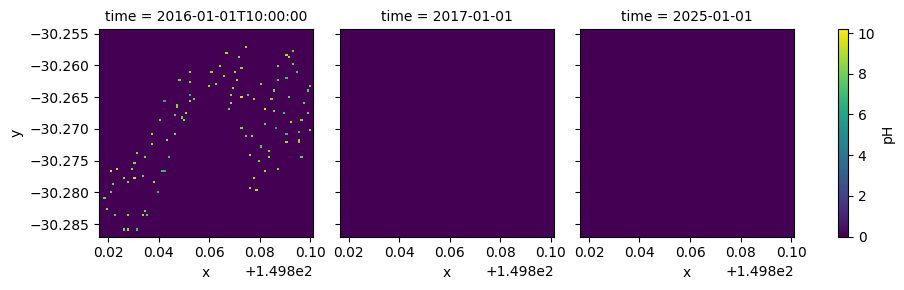

In [84]:
proc_ds["pH"].plot(x="x", y="y", col="time", col_wrap=3)

### Processing - Applying Ordinary Krigging

In [85]:
import pykrige
import xarray as xr 

krig_var = ["pH", "EC", "Sand", "Silt", "Clay", "ECa", "GammaK"]
mask = proc_ds.sel(time="2025-01-01")["eca"] > 0
for var in krig_var:
    grid = np.array([(proc_ds['x'].values[i], proc_ds['y'].values[j], proc_ds[var].values[0, i, j]) 
        for i in range(len(proc_ds['x'])) 
        for j in range(len(proc_ds['y']))
        if proc_ds[var].values[0, i, j] > 0
        ])
    if len(grid) != 0: 
        model = pykrige.ok.OrdinaryKriging(grid[:,0], grid[:,1], grid[:,2], "exponential")
        krigged_var, _ = model.execute("grid", proc_ds["x"].values, proc_ds["y"].values)
        krigged = np.stack([krigged_var.data] * len(proc_ds["time"]), axis=0)
        proc_ds["Krigged_" + var] = xr.DataArray(krigged, coords={"time": proc_ds["time"],"y": proc_ds["y"], "x": proc_ds["x"]})
        proc_ds["Krigged_" + var] = proc_ds["Krigged_" + var].where(mask.squeeze(), 0)


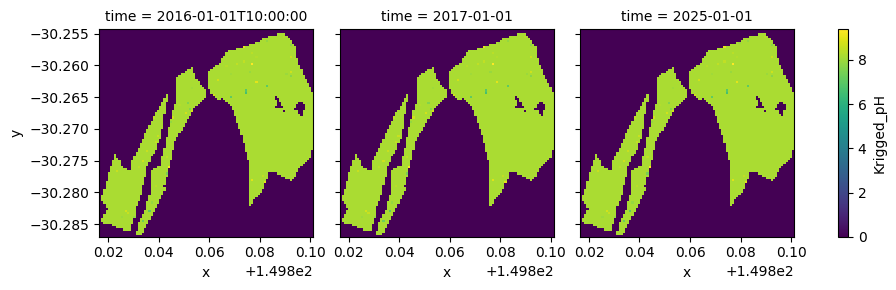

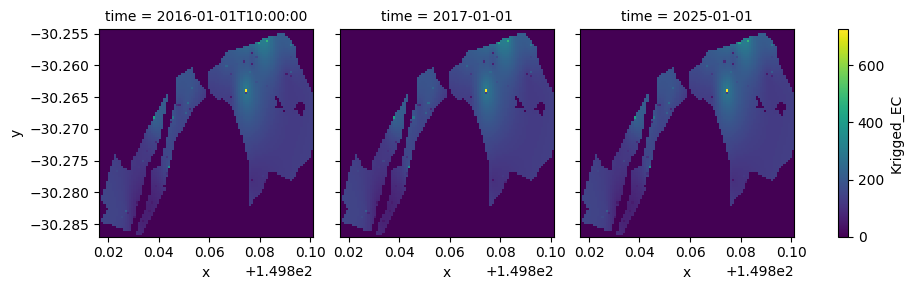

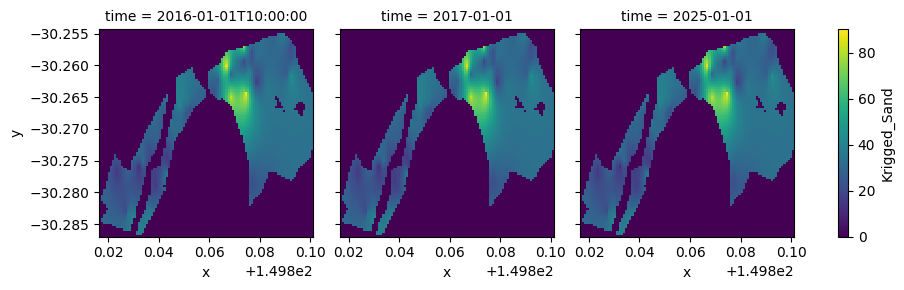

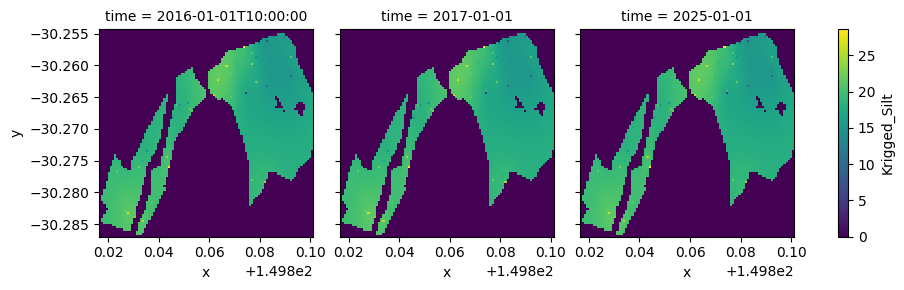

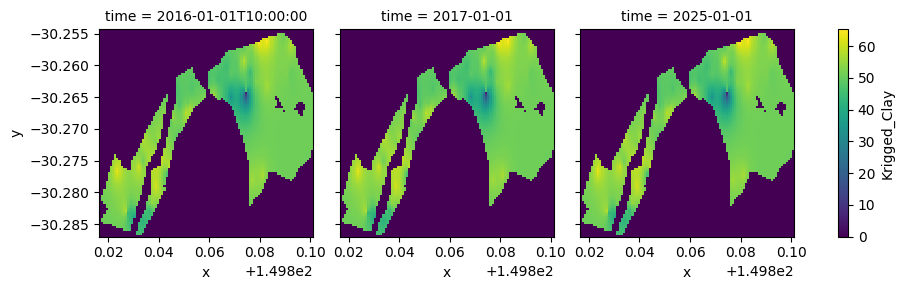

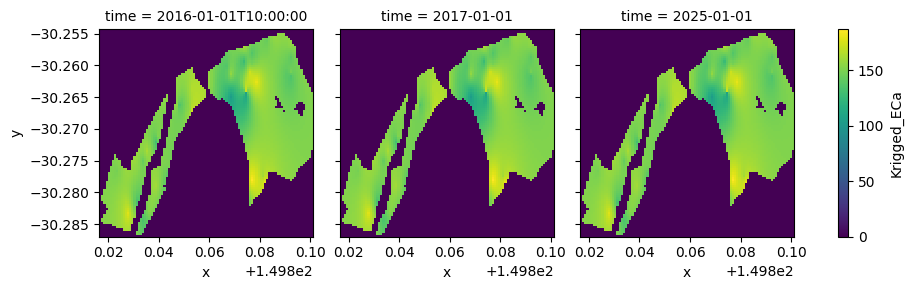

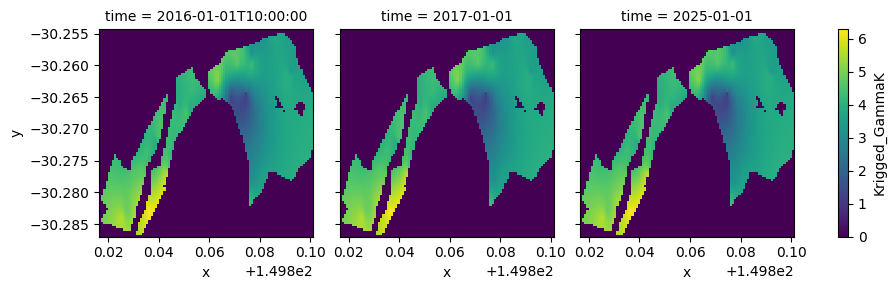

In [86]:
plot_vars = ["Krigged_" + var for var in krig_var]
for var in plot_vars:
    proc_ds[var].plot(x="x", y="y", col="time", col_wrap=3)

### Masking out Campey data

Notice that we only have masks for the Llara regions (L1, L3, L4) boundaries. We could use the mask layers to filter out the non masked data

In [87]:
mask = proc_ds["L1Boundary"].sel(time="2025-01-01") + proc_ds["L3Boundary"].sel(time="2025-01-01") + proc_ds["L4Boundary"].sel(time="2025-01-01")
masked_ds = proc_ds.where(mask.squeeze() != 0, 0)

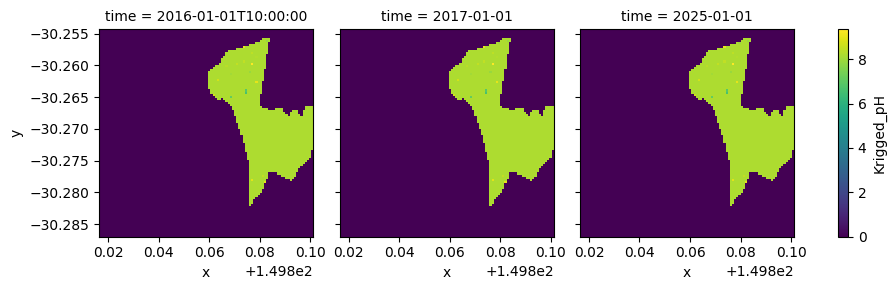

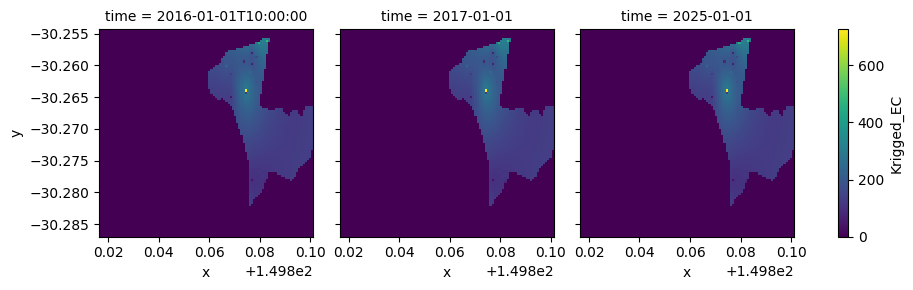

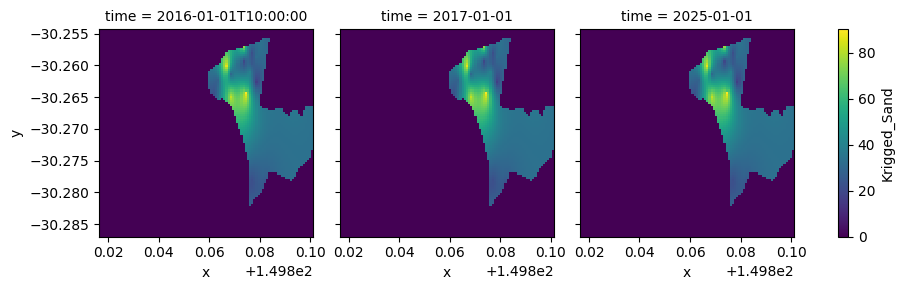

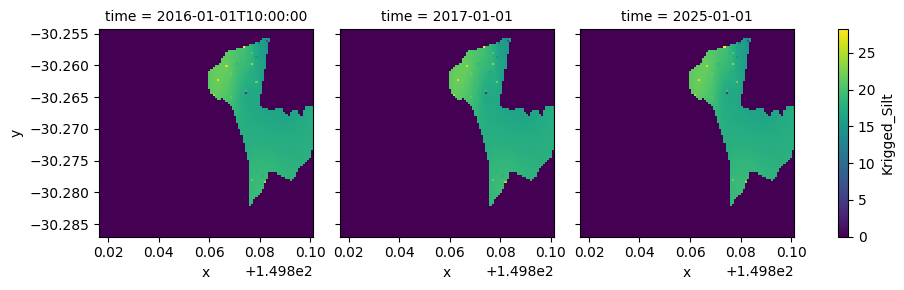

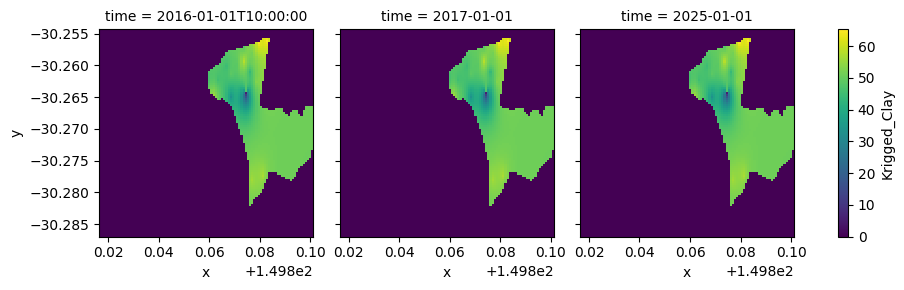

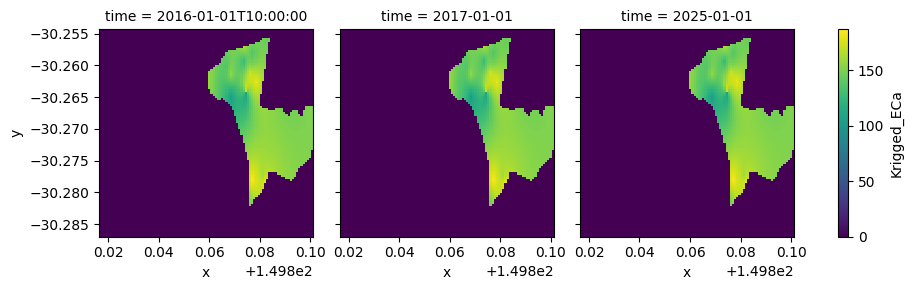

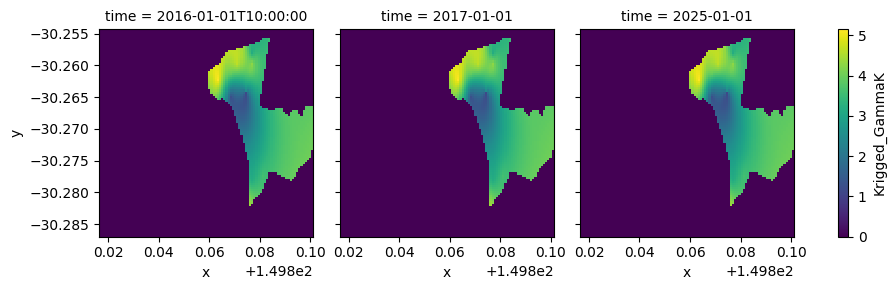

In [88]:
## Visualising other variables 
plot_vars = ["Krigged_" + var for var in krig_var]
for var in plot_vars:
    masked_ds[var].plot(x="x", y="y", col="time", col_wrap=3)

### Perform field zoning based on yield data

We will be using the [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) algorithm for clustering Llara into different management zones. We first try clustering based on yield data alone

In [92]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import numpy as np 

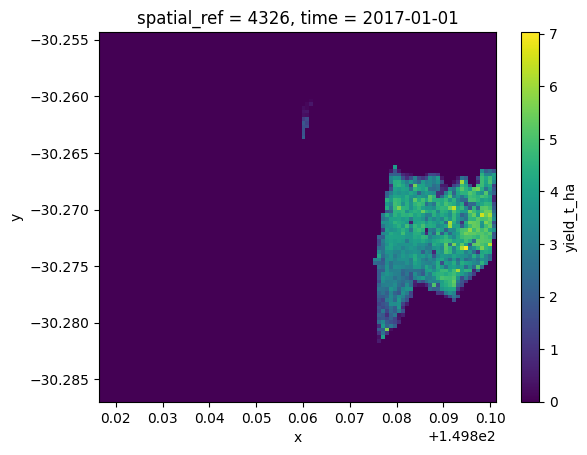

In [104]:
# Plotting Yield layer data
masked_ds["yield_t_ha"].sel(time="2017-01-01").plot(x="x", y="y")

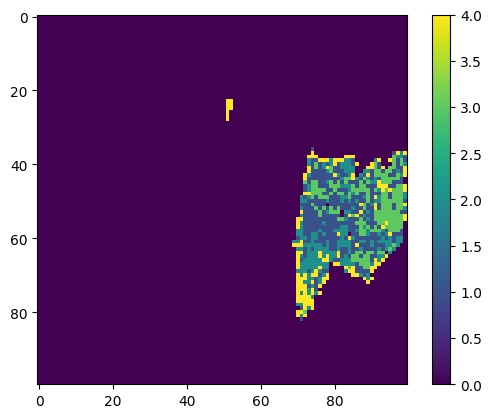

In [108]:
# Applying KMeans using 5 clusters
x_grid, y_grid = np.meshgrid(masked_ds["x"].values, masked_ds["y"].values, indexing="ij")
x_val = x_grid.reshape(-1,1) - x_grid.mean() / x_grid.std()
y_val = y_grid.reshape(-1,1) - y_grid.mean() / y_grid.std()
data = masked_ds.sel(time="2017-01-01").yield_t_ha.values[0,:,:].reshape(-1,1)
data_val = data - data.mean()/data.std()

X = [x_val, y_val, data_val]
X = np.concat(X, axis=-1)

clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(X).reshape((100, 100))
plt.imshow(cluster_labels)
plt.colorbar()
plt.show() 

### Perform field zoning using soil measurements

Since soil data is sparse, we will only perform zoning based on overlapping locations

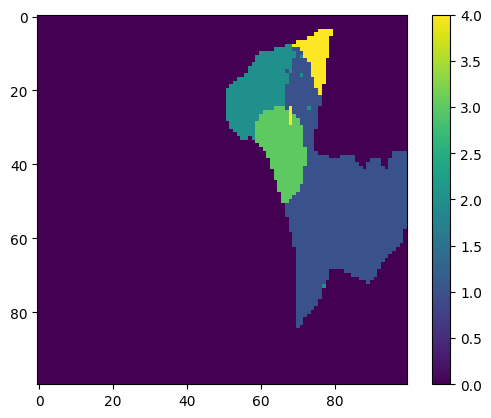

In [180]:
variables = masked_ds[["Krigged_pH", "Krigged_EC", "Krigged_Sand", "Krigged_Silt", 
                       "Krigged_Clay", "Krigged_ECa", "Krigged_GammaK"]].sel(time="2016-01-01")
x_grid, y_grid = np.meshgrid(masked_ds["x"].values, masked_ds["y"].values, indexing="ij")
x_val = x_grid.reshape(-1,1) - x_grid.mean() / x_grid.std()
y_val = y_grid.reshape(-1,1) - y_grid.mean() / y_grid.std()
X = [x_val, y_val] 

# Preprocess variables
for var in variables:
    values = variables[var].values[0,:,:].reshape(-1,1)
    # Perform standard scaling to avoid scaling influence
    mean = values[values != 0].mean() 
    std = values[values != 0].std()
    X.append((values - mean)/std)
X = np.concat(X, axis=-1)

# Cluster
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(X)
plt.imshow(cluster_labels.reshape(100,100))
plt.colorbar()
plt.show() 

### Using GMM

In [173]:
features_df = masked_ds.sel(time="2016-01-01T10:00").to_dataframe().reset_index()
features_df = features_df.loc[:, ["y", "x", "Krigged_pH", "Krigged_EC", "Krigged_Sand", "Krigged_Silt", "Krigged_Clay", "Krigged_ECa", "Krigged_GammaK"]]
features_df.rename(columns={"y": "lat", "x": "lon"}, inplace=True)
features_position = features_df.loc[:,["lat", "lon"]]
features_X = features_df.loc[:, ["Krigged_pH", "Krigged_EC", "Krigged_Sand", "Krigged_Silt", "Krigged_Clay", "Krigged_ECa", "Krigged_GammaK"]]
for col in features_X.columns: 
    mean = features_X[features_X[col] != 0][col].mean()
    std = features_X[features_X[col] != 0][col].std()
    features_X[col] = (features_X[col] - mean)/ std

In [174]:
features_df.head()

,lat,lon,Krigged_pH,Krigged_EC,Krigged_Sand,Krigged_Silt,Krigged_Clay,Krigged_ECa,Krigged_GammaK
0,-30.254496,149.816895,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-30.254496,149.817742,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-30.254496,149.818590,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-30.254496,149.819437,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-30.254496,149.820284,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
from SpatialCluster.methods.GMM import GMM_Clustering
GMM_areas_to_points, GMM_clusters = GMM_Clustering(features_X, features_position, n_clusters = 5, covariance_type = "full", tol=1e-3, reg_covar=1e-6)

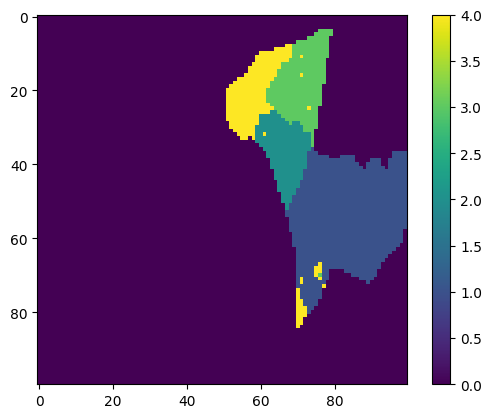

In [178]:
plt.imshow(GMM_clusters.reshape(100,100))
plt.colorbar()
plt.show() 

### Use TDI

In [179]:
from SpatialCluster.methods.TDI import TDI_Clustering
TDI_areas_to_points, TDI_clusters = TDI_Clustering(features_X, features_position, n_clusters=5, A=None, k=20, leafsize=10)

/home/harry/CodingProject/mccn-case-studies/.venv/lib/python3.11/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/home/harry/CodingProject/mccn-case-studies/.venv/lib/python3.11/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


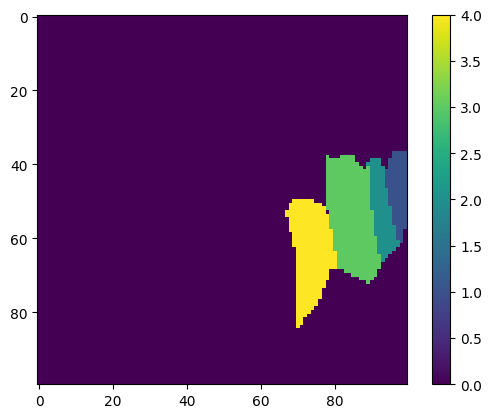

In [181]:
plt.imshow(TDI_clusters.reshape(100,100))
plt.colorbar()
plt.show() 

### Clean up

In [142]:
import shutil
shutil.rmtree(output_path)